**0 | Setup & Data Load**

In [5]:
# CORE
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MODELLING
from sklearn.preprocessing   import StandardScaler, OneHotEncoder
from sklearn.compose         import ColumnTransformer
from sklearn.pipeline        import Pipeline
from sklearn.decomposition   import PCA
from sklearn.cluster         import KMeans
from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics         import mean_squared_error, silhouette_score

# CONFIG
plt.style.use("default")             # clean look
sns.set_theme(context="notebook")

# DATA
df = pd.read_csv("cafc-open-gouv-database-2021-01-01-to-2025-03-31-extracted-2025-04-01.csv", parse_dates=["Date Received"])

**1 | High-Level Overview**

In [10]:
display(df.head())          # first 5 rows
df.info()                   # dtypes & non-null counts
df.select_dtypes(include="number").describe().T
df.describe(include="object").T

Number ID Date Received Complaint Received Type        Country  \
0          1    2021-01-02            CAFC Website         Canada   
1          2    2021-01-02            CAFC Website  Not Specified   
2          3    2021-01-02            CAFC Website         Canada   
3          4    2021-01-02            CAFC Website         Canada   
4          5    2021-01-02            CAFC Website         Canada   

  Province/State Fraud and Cybercrime Thematic Categories Solicitation Method  \
0   Saskatchewan                              Merchandise       Other/unknown   
1  Not Specified                              Merchandise            Internet   
2         Quebec                           Identity Fraud       Other/unknown   
3   Saskatchewan                                 Phishing               Email   
4   Saskatchewan                              Merchandise       Other/unknown   

          Gender Language of Correspondence                Victim Age Range   \
0  Not Available              Not Available  'Not Available / non disponible   
1  Not Available              Not Available  'Not Available / non disponible   
2           Male                     French                         '40 - 49   
3           Male                    English                         '30 - 39   
4           Male              Not Available                         '60 - 69   

  Complaint Type  Number of Victims Dollar Loss  
0        Attempt                  0      $0.00   
1         Victim                  1  $1,000.00   
2         Victim                  1      $0.00   
3         Victim                  1      $0.00   
4         Victim                  1    $222.73

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328649 entries, 0 to 328648
Data columns (total 13 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   Number ID                                 328649 non-null  int64         
 1   Date Received                             328649 non-null  datetime64[ns]
 2   Complaint Received Type                   328649 non-null  object        
 3   Country                                   328649 non-null  object        
 4   Province/State                            328649 non-null  object        
 5   Fraud and Cybercrime Thematic Categories  328649 non-null  object        
 6   Solicitation Method                       328649 non-null  object        
 7   Gender                                    328649 non-null  object        
 8   Language of Correspondence                328649 non-null  object        
 9   Victim Age Rang

count unique  \
Complaint Received Type                   328649     10   
Country                                   328649    159   
Province/State                            328649     67   
Fraud and Cybercrime Thematic Categories  328649     39   
Solicitation Method                       328649     14   
Gender                                    328649      6   
Language of Correspondence                328649      3   
Victim Age Range                          328649     14   
Complaint Type                            328649      5   
Dollar Loss                               328649  24630   

                                                                      top  \
Complaint Received Type                                      CAFC Website   
Country                                                            Canada   
Province/State                                                    Ontario   
Fraud and Cybercrime Thematic Categories                   Identity Fraud   
Solicitation Method                                         Other/unknown   
Gender                                                             Female   
Language of Correspondence                                        English   
Victim Age Range                          'Not Available / non disponible   
Complaint Type                                                     Victim   
Dollar Loss                                                        $0.00    

                                            freq  
Complaint Received Type                   174178  
Country                                   249795  
Province/State                             96150  
Fraud and Cybercrime Thematic Categories   75475  
Solicitation Method                        95692  
Gender                                    123639  
Language of Correspondence                182023  
Victim Age Range                           98111  
Complaint Type                            212984  
Dollar Loss                               248201

**2 | Data Cleaning & Feature Engineering**

In [17]:
# 2.1  Standardise missing values
df.replace({
    "Not Available": np.nan,
    "Not Specified": np.nan,
    "Not Available / non disponible": np.nan
}, inplace=True)

# 2.2  Dates → calendar features
df["year"] = df["Date Received"].dt.year
df["month"] = df["Date Received"].dt.month_name().str[:3]

# 2.3  Dollar Loss: clean and log-transform
# Remove currency symbols or commas if they exist (optional, but safe)
df["Dollar Loss"] = df["Dollar Loss"].astype(str).str.replace(r"[\$,]", "", regex=True)

# Convert to numeric, coercing errors to NaN
df["Dollar Loss"] = pd.to_numeric(df["Dollar Loss"], errors="coerce")

# Apply log1p transformation
df["Dollar Loss_log"] = np.log1p(df["Dollar Loss"])

**3 | Univariate Analysis**

**3.1 Non-graphical**

In [22]:
for col in ["Dollar Loss", "Number of Victims"]:
    print(col, "\n", df[col].describe(), "\n")

for col in df.select_dtypes("object"):
    print(df[col].value_counts(dropna=False).head(), "\n")

Dollar Loss 
 count    3.286490e+05
mean     6.996873e+03
std      1.023280e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.361500e+07
Name: Dollar Loss, dtype: float64 

Number of Victims 
 count    328649.000000
mean          0.648059
std           0.477576
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: Number of Victims, dtype: float64 

Complaint Received Type
CAFC Website    174178
Phone           116794
Email            21633
NCFRS            15537
Other              424
Name: count, dtype: int64 

Country
Canada            249795
NaN                74367
United States       2074
India                245
United Kingdom       157
Name: count, dtype: int64 

Province/State
Ontario             96150
NaN                 77767
Quebec              67041
British Columbia    31604
Alberta             26189
Name: count, dtype: int64 

Fraud and Cybercrime Themat

**3.2 Graphical**

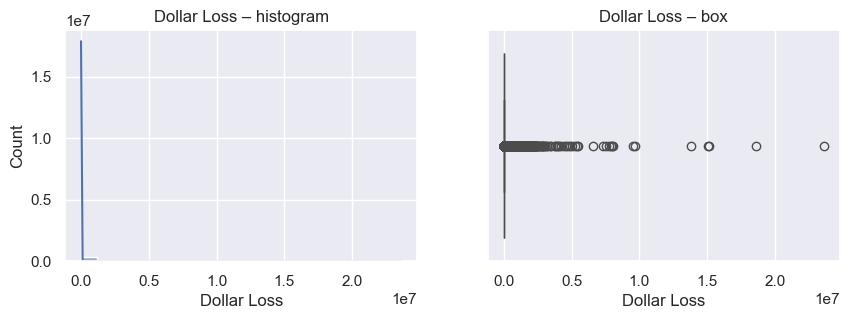

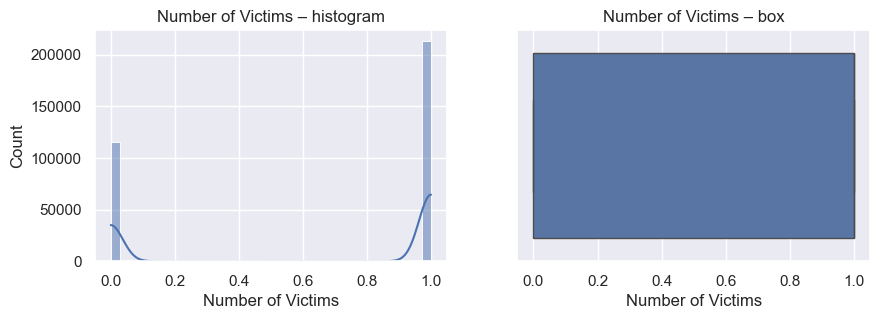

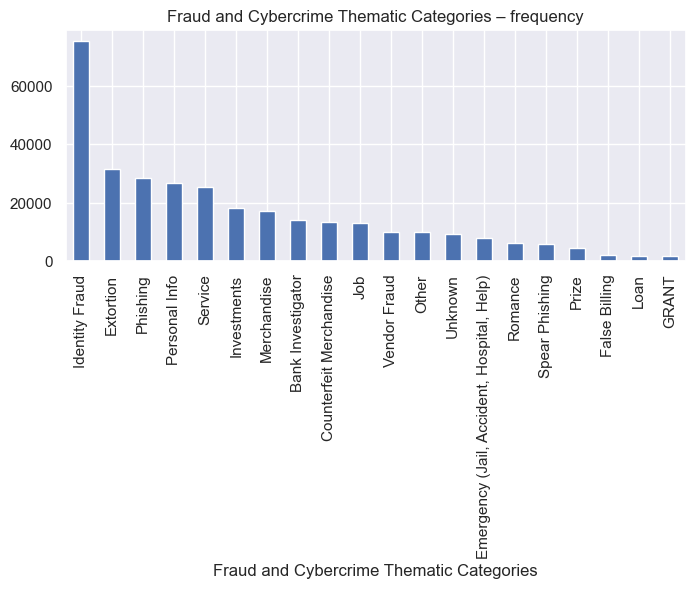

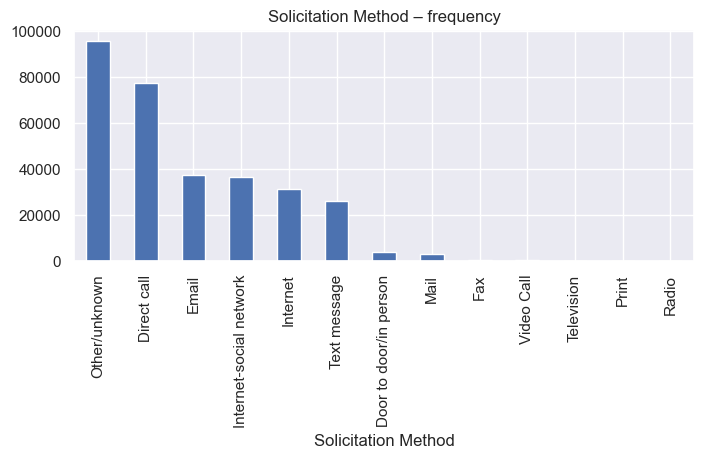

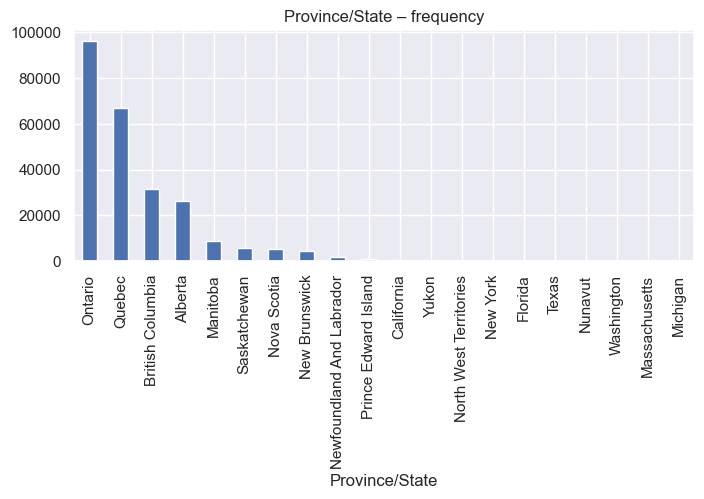

In [25]:
# Numeric
num_cols = ["Dollar Loss", "Number of Victims"]
for col in num_cols:
    fig, ax = plt.subplots(1,2, figsize=(10,3))
    sns.histplot(df[col], ax=ax[0], kde=True);  ax[0].set_title(f"{col} – histogram")
    sns.boxplot(x=df[col], ax=ax[1]);           ax[1].set_title(f"{col} – box")
    plt.show()

# Categorical (top-20 only to keep it readable)
cat_cols = ["Fraud and Cybercrime Thematic Categories",
            "Solicitation Method", "Province/State"]
for col in cat_cols:
    df[col].value_counts().head(20).plot(kind="bar", figsize=(8,3),
                                         title=f"{col} – frequency")
    plt.show()

**4 | Bivariate Analysis (target vs. single predictor)**

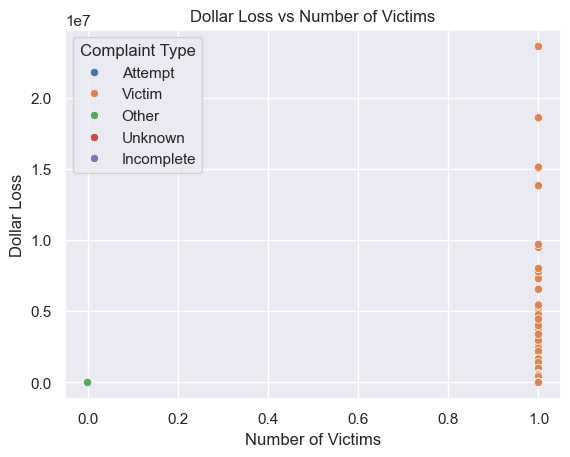

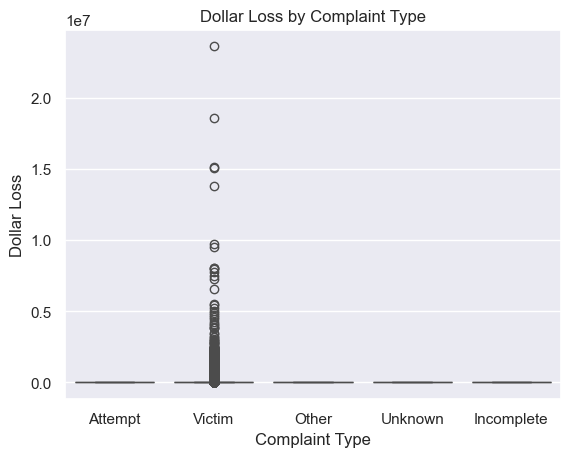

In [28]:
target = "Dollar Loss"

# Numeric ↔ target
sns.scatterplot(data=df, x="Number of Victims", y=target, hue="Complaint Type")
plt.title("Dollar Loss vs Number of Victims"); plt.show()

# Categorical ↔ target
sns.boxplot(data=df, x="Complaint Type", y=target)
plt.title("Dollar Loss by Complaint Type"); plt.show()

In [30]:
df.groupby("Complaint Type")[target].agg(["mean","median","count"])


mean  median   count
Complaint Type                              
Attempt             0.000000     0.0  108038
Incomplete          0.000000     0.0     473
Other               0.000000     0.0    6128
Unknown             0.000000     0.0    1026
Victim          10796.657216     0.0  212984

**5 | Multivariate Analysis**

**Correlation heat-map (numeric only)**

<Axes: >

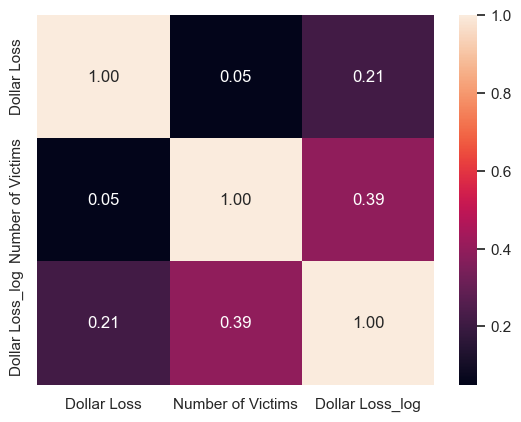

In [34]:
sns.heatmap(df[num_cols + ["Dollar Loss_log"]].corr(), annot=True, fmt=".2f")


**Pair plot (combination of scatter & KDE)**

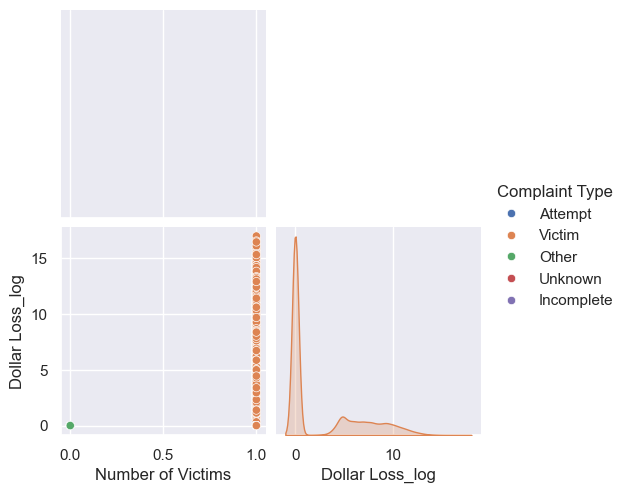

In [39]:
sns.pairplot(df, vars=["Number of Victims","Dollar Loss_log"],
             hue="Complaint Type", corner=True)

**Run chart (trend over time)**

/var/folders/yz/1bk9h9m96d99ww_yjk53jqr00000gn/T/ipykernel_5013/4128557833.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index("Date Received")["Dollar Loss"].resample("M").sum()\


Text(0, 0.5, '$')

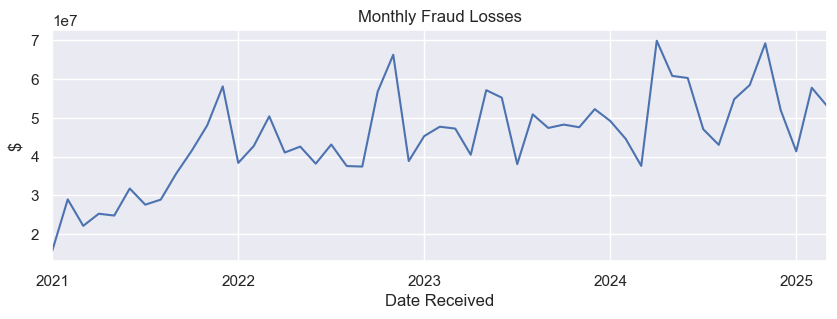

In [50]:
df.set_index("Date Received")["Dollar Loss"].resample("M").sum()\
  .plot(figsize=(10,3), title="Monthly Fraud Losses"); plt.ylabel("$")


**Bubble / multi-dimensional example**

Text(0.5, 1.0, 'Victims vs Loss (bubble size = year)')

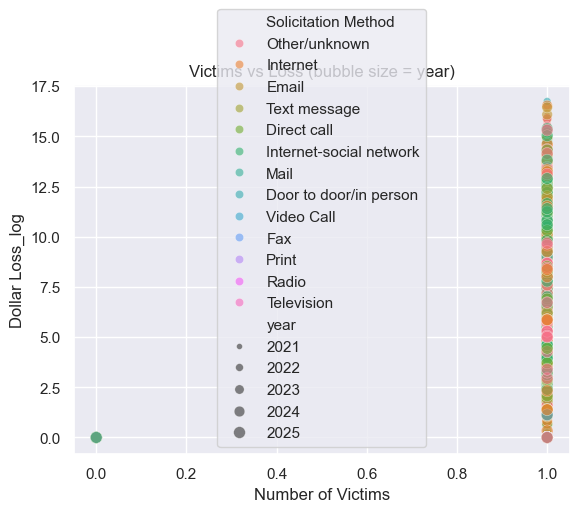

In [53]:
sns.scatterplot(data=df, x="Number of Victims", y="Dollar Loss_log",
                size="year", hue="Solicitation Method", alpha=.6)
plt.title("Victims vs Loss (bubble size = year)")


**6 | Clustering & Dimension Reduction**

Text(0.5, 1.0, 'K-means clusters (PCA-reduced space)')

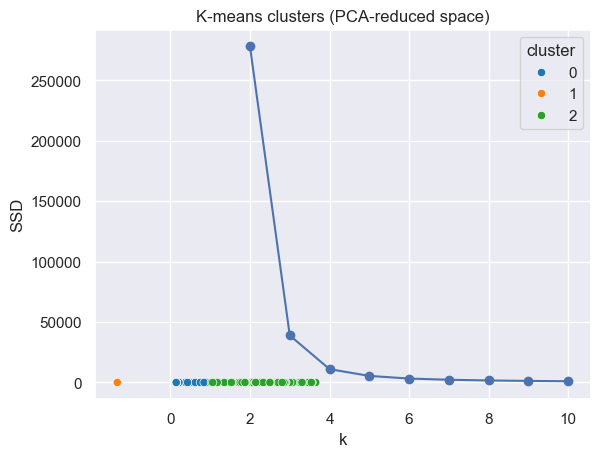

In [56]:
# 6.1  Prep: numeric-only to illustrate; you can dummy-encode categoricals too
to_scale = ["Number of Victims", "Dollar Loss_log"]
X        = StandardScaler().fit_transform(df[to_scale])

# 6.2  Elbow method to find k
ssd = []
for k in range(2,11):
    ssd.append(KMeans(n_clusters=k, n_init='auto',
                      random_state=42).fit(X).inertia_)
plt.plot(range(2,11), ssd, marker="o"); plt.xlabel("k"); plt.ylabel("SSD")

# 6.3  Final model
k = 3                          # choose from elbow / silhouette
km = KMeans(n_clusters=k, n_init='auto', random_state=42)
df["cluster"] = km.fit_predict(X)

# 6.4  Visualise with PCA to 2-D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["cluster"], palette="tab10")
plt.title("K-means clusters (PCA-reduced space)")


**Enhanced Fraud Case Segmentation with Mixed-Type Clustering and PCA**

=== Numeric Summary by Cluster ===
         Number of Victims  Dollar Loss_log
cluster                                    
0                      1.0         0.019212
1                      0.0         0.000000
2                      1.0         7.516482


=== Province Distribution by Cluster ===
cluster  Province/State  
0        Ontario             0.357505
         Quebec              0.329780
         British Columbia    0.119123
         Alberta             0.093776
         Manitoba            0.030673
                               ...   
2        Rhode Island        0.000037
         Mississippi         0.000019
         Nebraska            0.000019
         South Dakota        0.000019
         West Virginia       0.000019
Name: proportion, Length: 187, dtype: float64


=== Fraud Category Distribution by Cluster ===
cluster  Fraud and Cybercrime Thematic Categories
0        Identity Fraud                              0.558296
         Personal Info                             

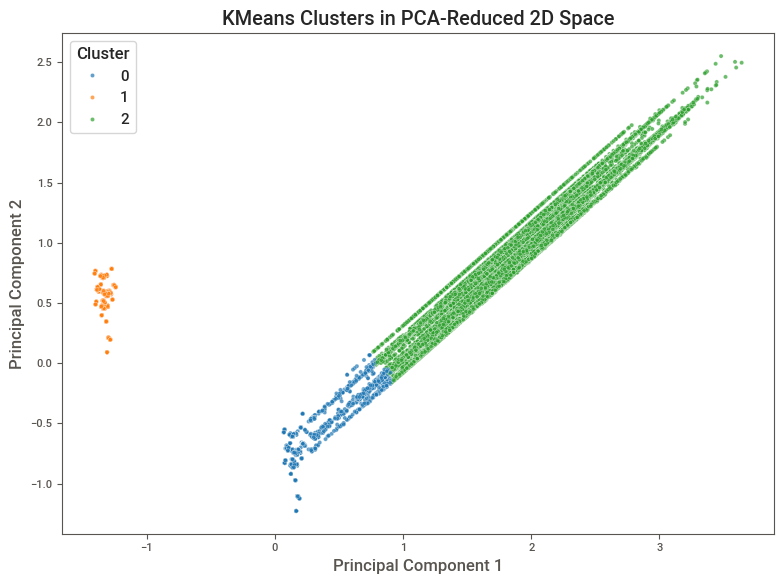

In [84]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Summary stats for numeric features by cluster
print("=== Numeric Summary by Cluster ===")
print(df.groupby("cluster")[["Number of Victims", "Dollar Loss_log"]].mean())
print("\n")

# 2. Categorical distribution by cluster
print("=== Province Distribution by Cluster ===")
print(df.groupby("cluster")["Province/State"].value_counts(normalize=True))
print("\n")

print("=== Fraud Category Distribution by Cluster ===")
print(df.groupby("cluster")["Fraud and Cybercrime Thematic Categories"].value_counts(normalize=True))
print("\n")

# 3. PCA Visualization of clusters
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_combined)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["cluster"], palette="tab10", alpha=0.7)
plt.title("KMeans Clusters in PCA-Reduced 2D Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


**7 | Predictive Modelling (illustrative)**

In [59]:
num_attribs = ["Number of Victims"]
cat_attribs = ["Fraud and Cybercrime Thematic Categories",
               "Solicitation Method", "Complaint Type"]

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_attribs),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs)
])

X = df[num_attribs + cat_attribs]
y = df["Dollar Loss_log"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2,
                                                    random_state=42)

model = Pipeline(steps=[("prep", preprocess),
                       ("est" , LinearRegression())])

model.fit(X_train, y_train)
pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print(f"Test RMSE: {rmse:0.3f}")


Test RMSE: 2.166


7.2 Binary Classification (Victim vs Attempt)

In [61]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- Assume your dataframe 'df' is already loaded and cleaned ---

# 1. Create binary target: Victim (1) vs Attempt (0)
df["is_victim"] = df["Complaint Type"].map(lambda x: 1 if "Victim" in str(x) else 0)

# 2. Define features
num_attribs = ["Number of Victims"]
cat_attribs = ["Fraud and Cybercrime Thematic Categories", "Solicitation Method"]

# 3. Preprocessing pipeline
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_attribs),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs)
])

# 4. Prepare feature matrix X and target y
X = df[num_attribs + cat_attribs]
y = df["is_victim"]

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Model pipeline
model = Pipeline(steps=[
    ("prep", preprocess),
    ("est", LogisticRegression(max_iter=1000))
])

# 7. Fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 8. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0
Confusion Matrix:
 [[23141     0]
 [    0 42589]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23141
           1       1.00      1.00      1.00     42589

    accuracy                           1.00     65730
   macro avg       1.00      1.00      1.00     65730
weighted avg       1.00      1.00      1.00     65730



**Quick “Cheat Commands” for Fast Profiling**

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████| 18/18 [00:03<00:00,  5.49it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

                                             |      | [  0%]   00:00 -> (? left)


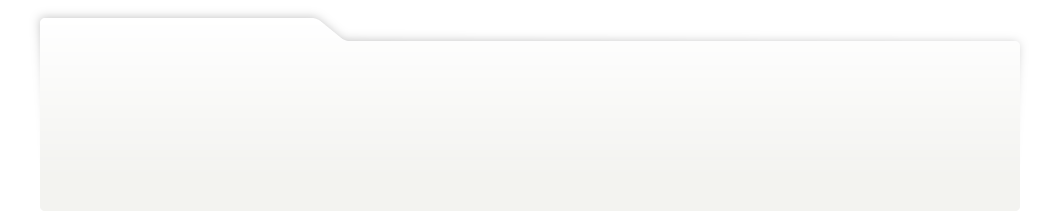
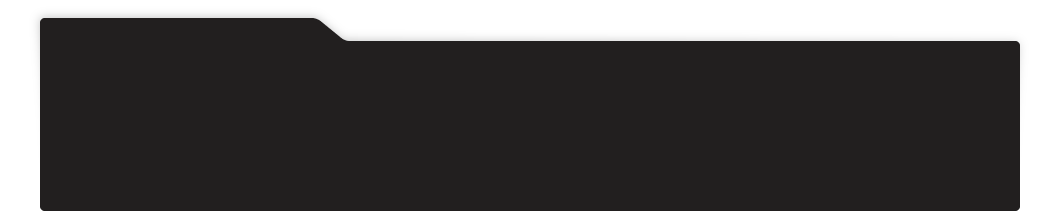
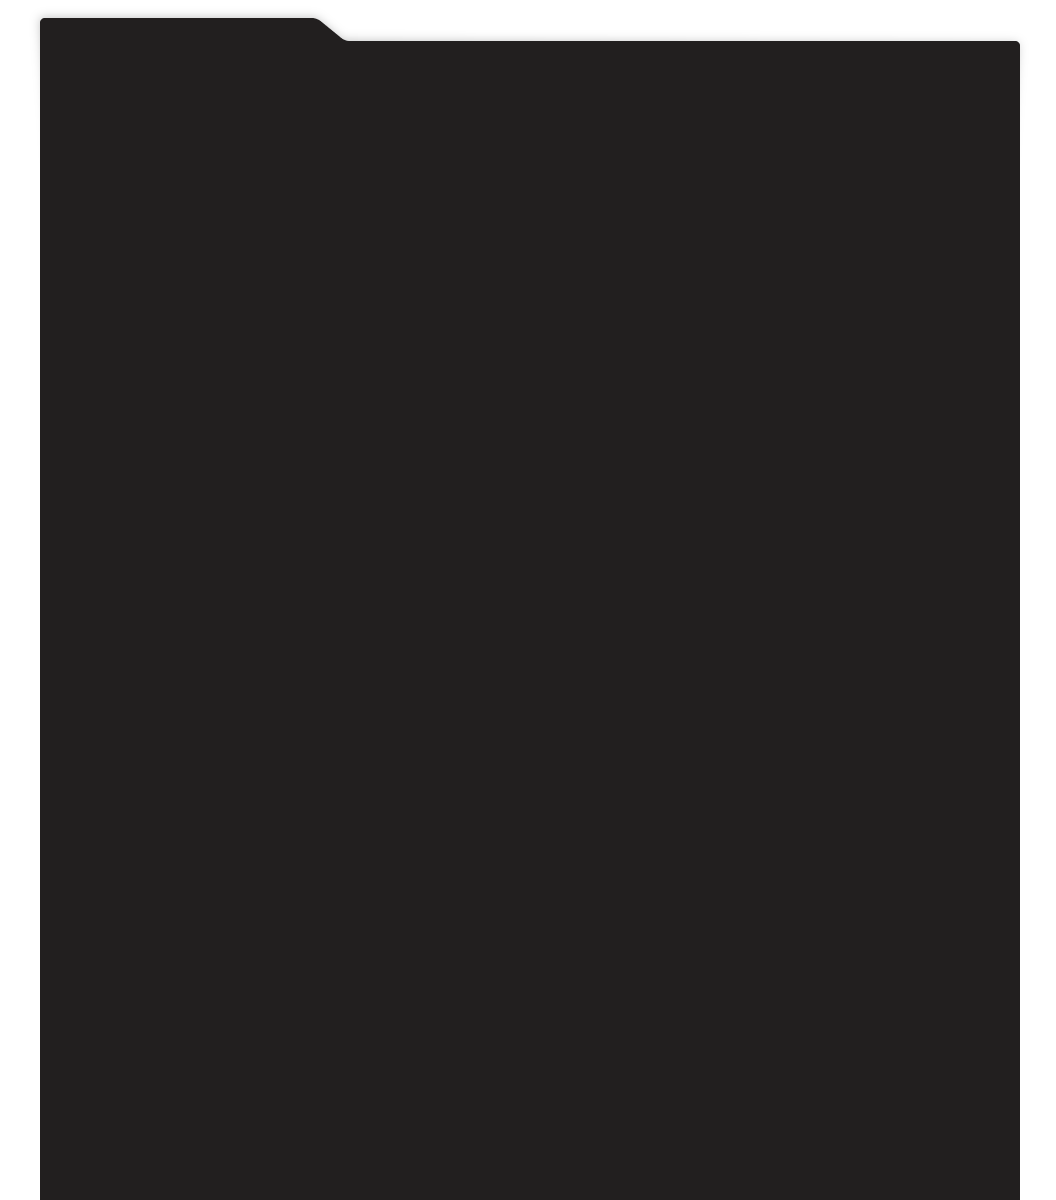
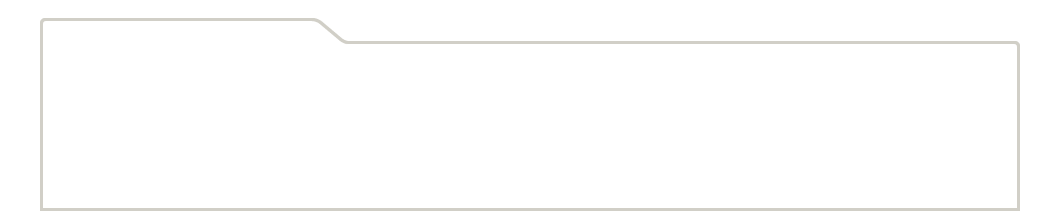
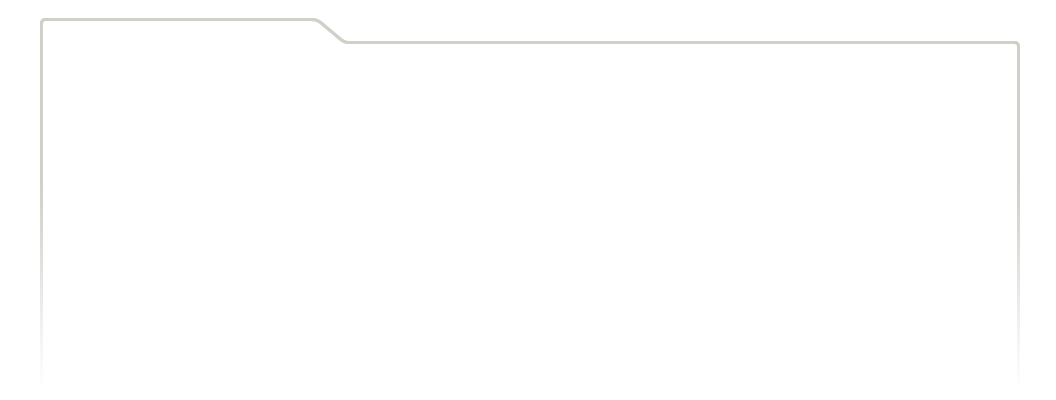
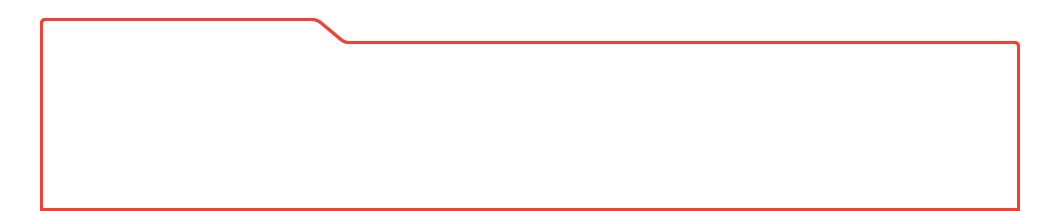
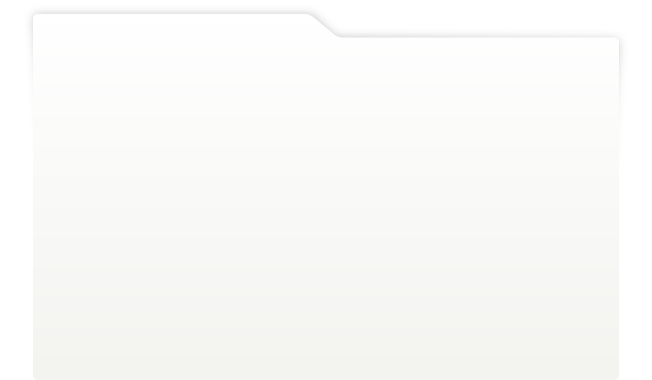
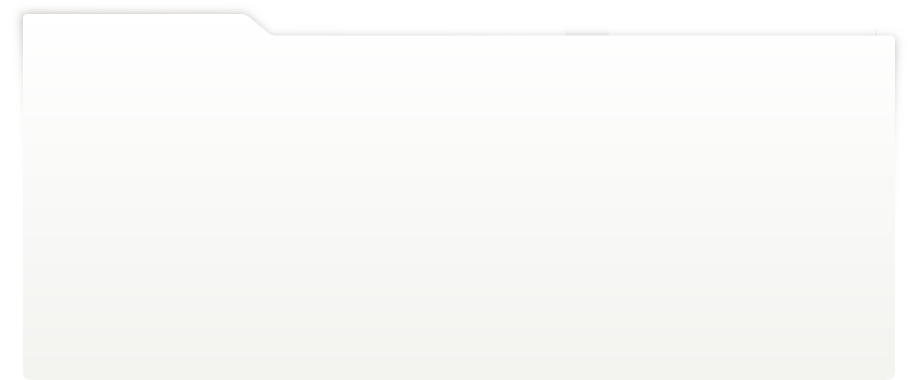
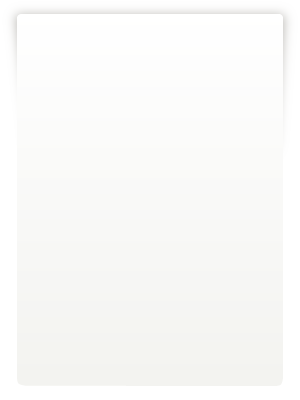
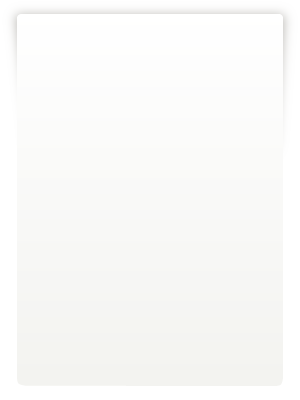
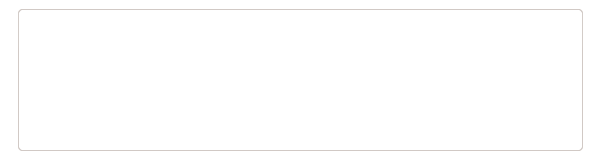
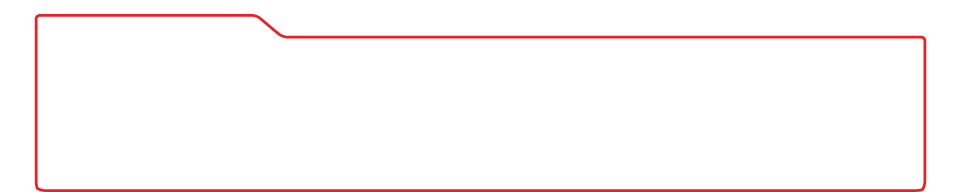
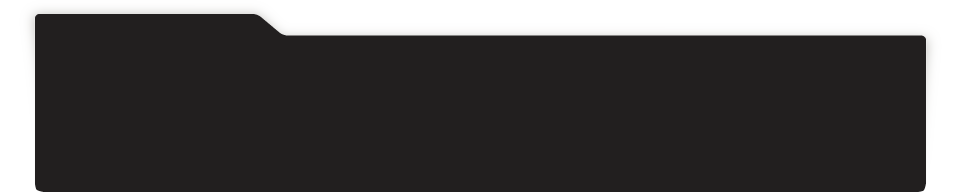
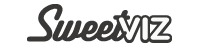
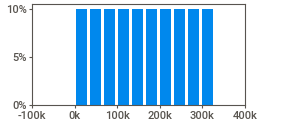
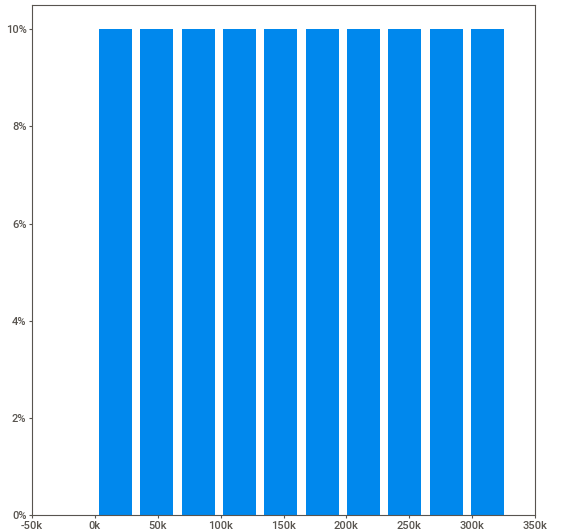
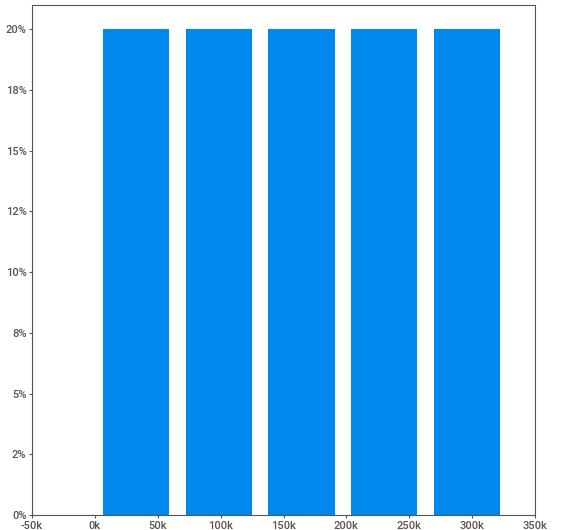
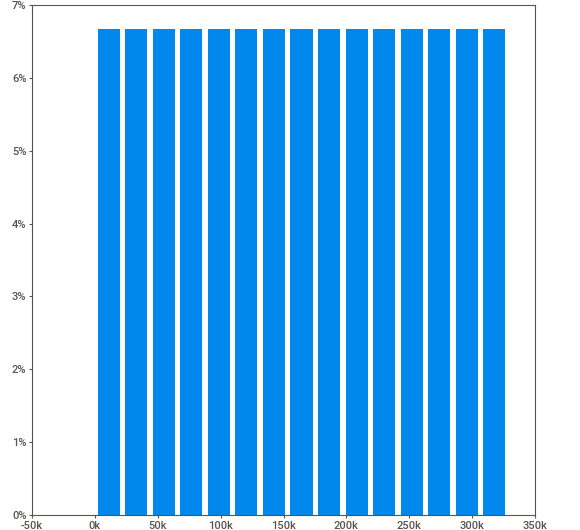
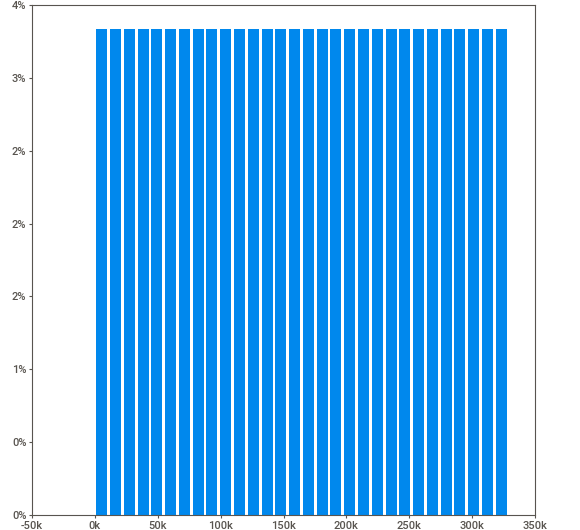
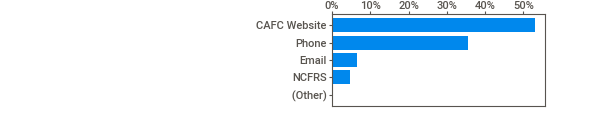
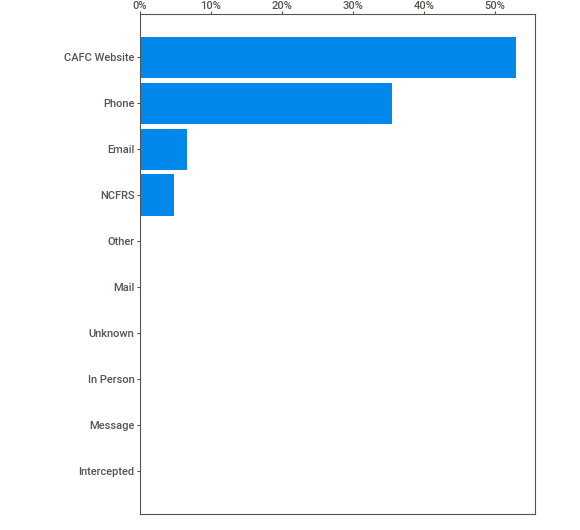
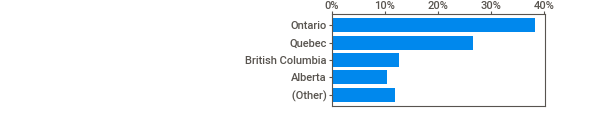
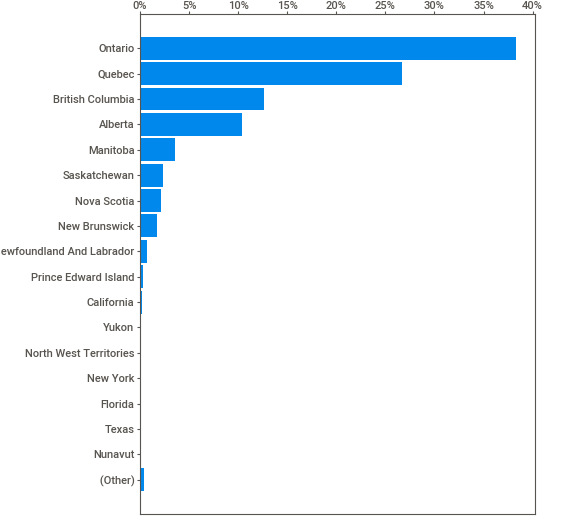
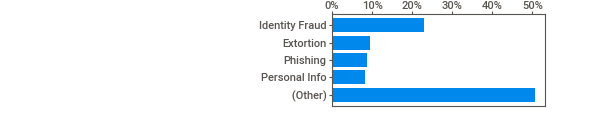
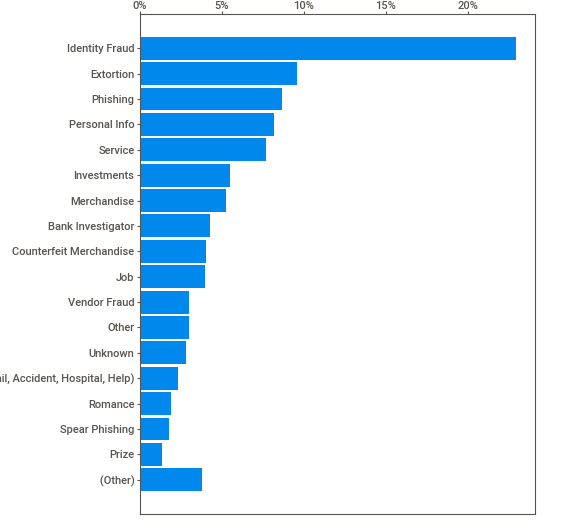
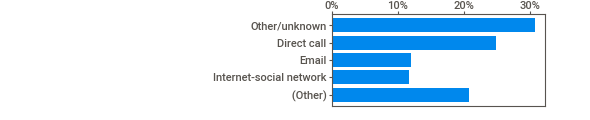
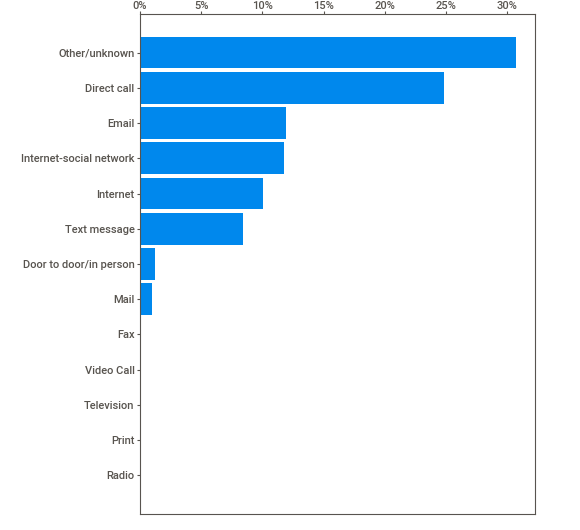
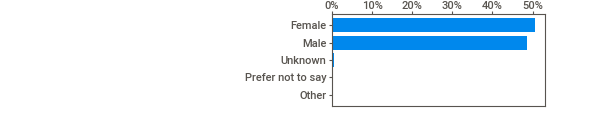
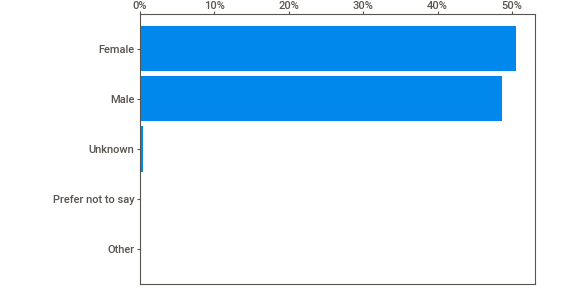
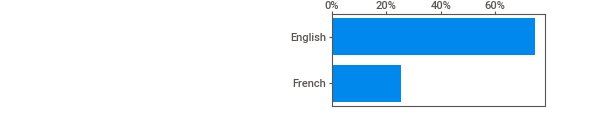
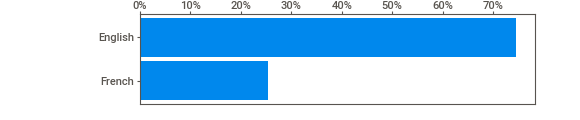
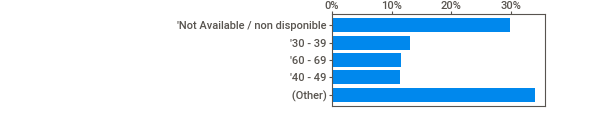
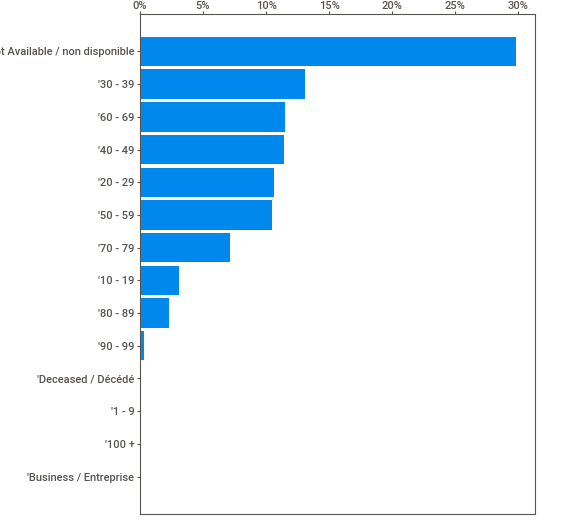
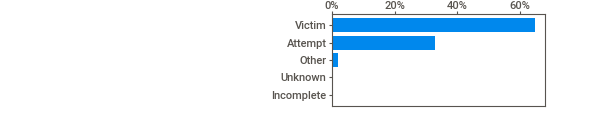
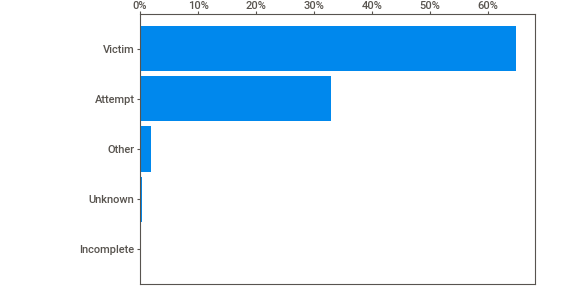
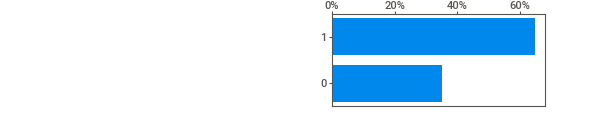
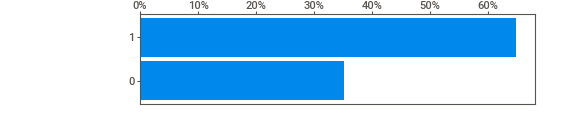
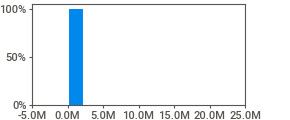
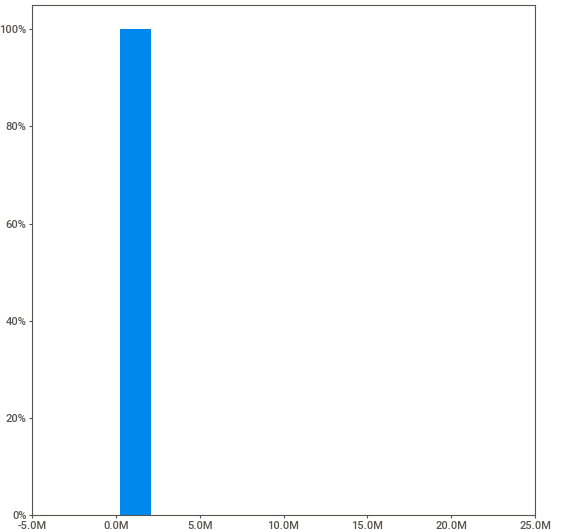
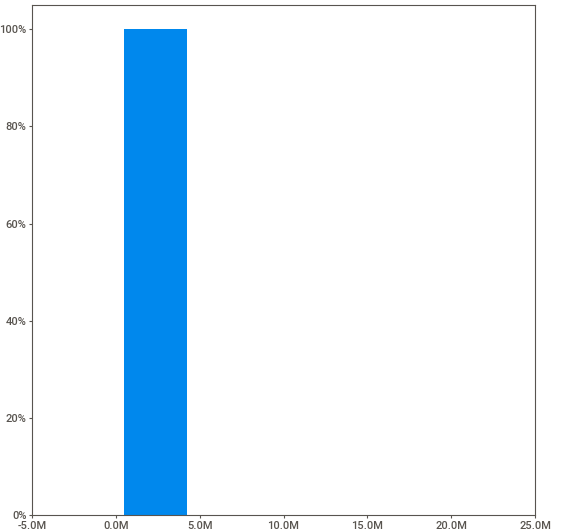
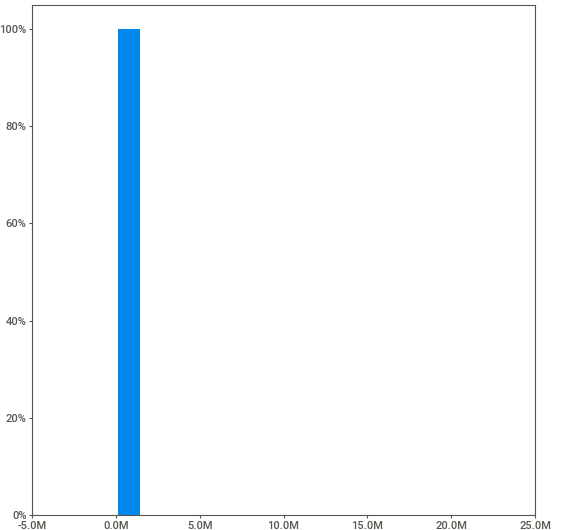
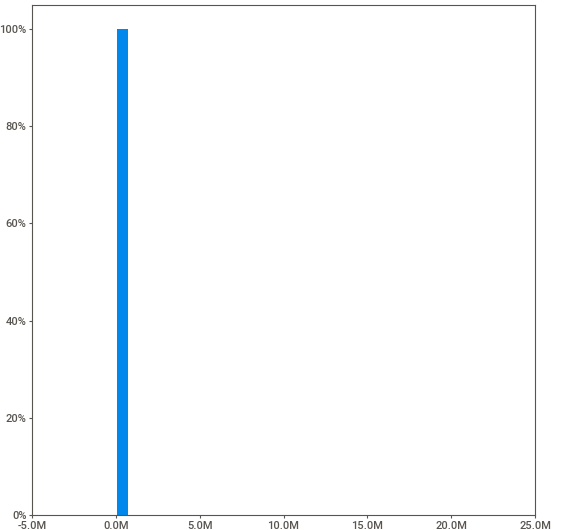
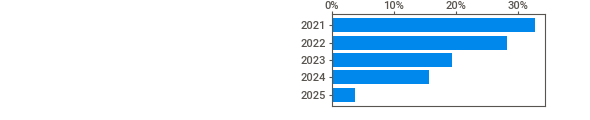
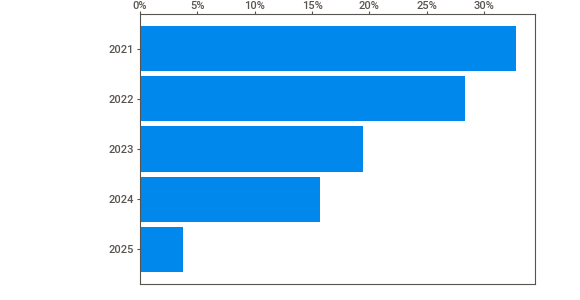
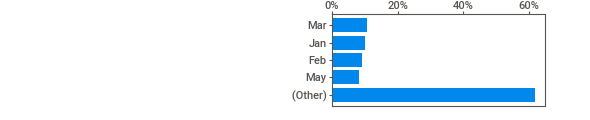
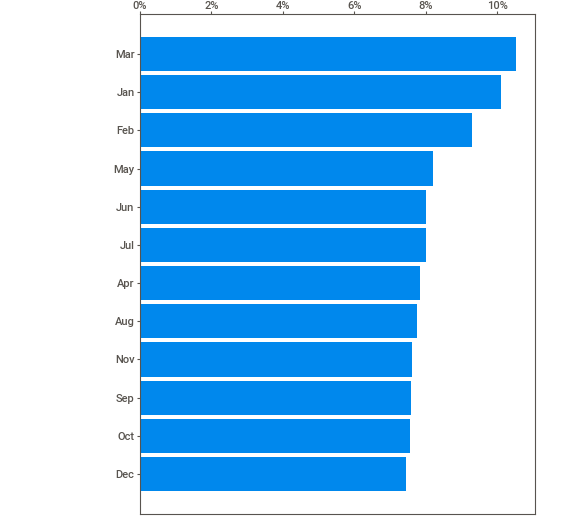
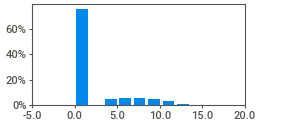
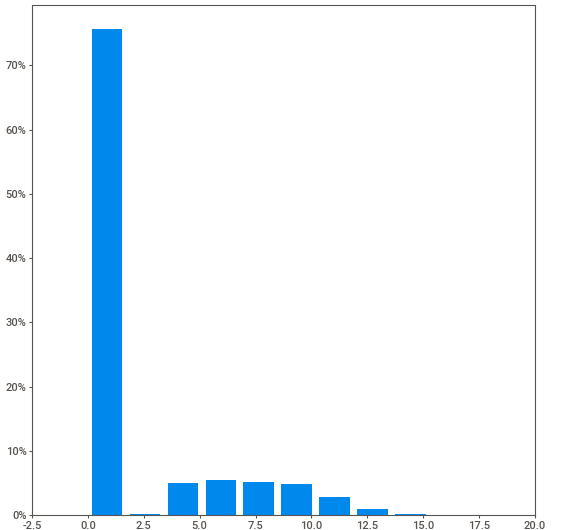
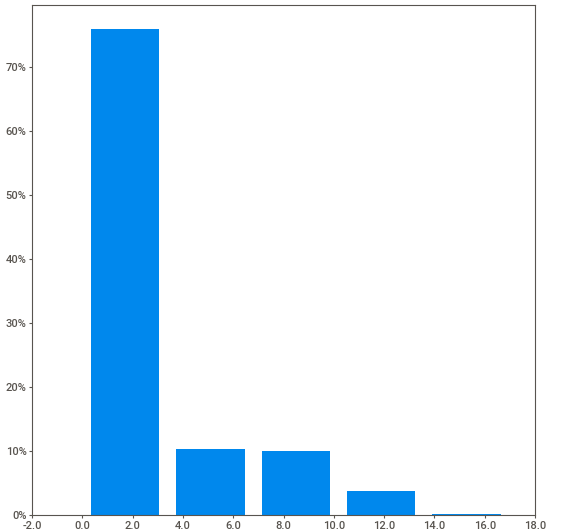
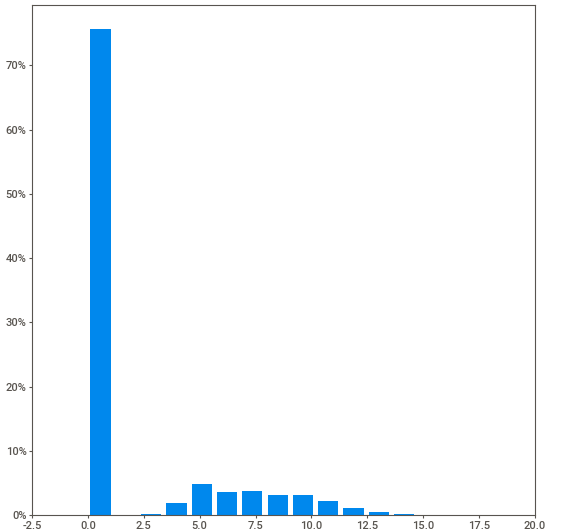
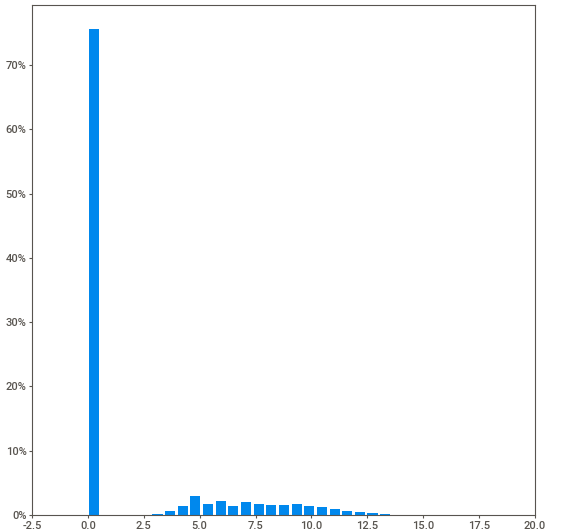
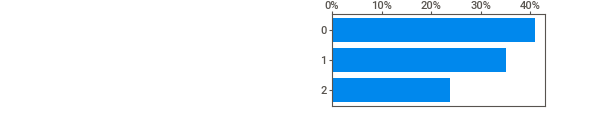
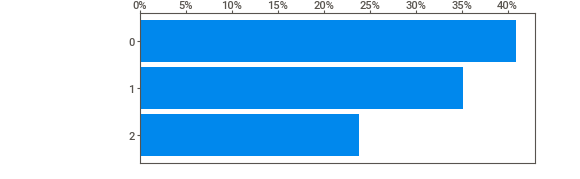
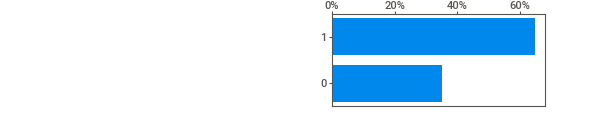
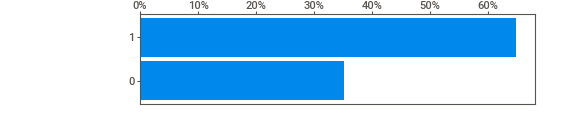
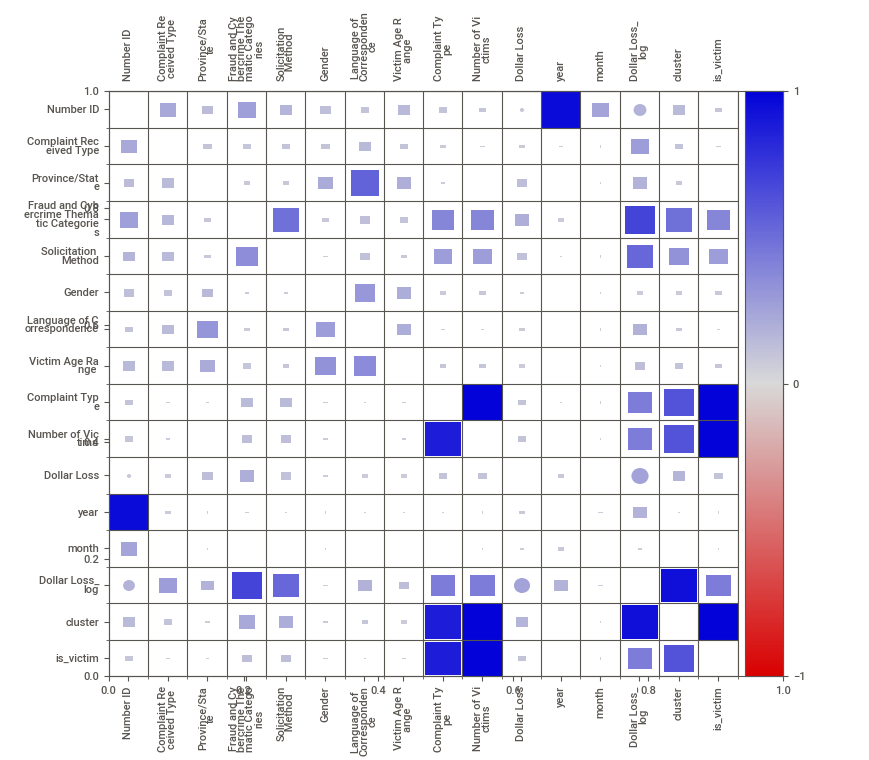
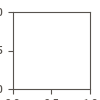

In [65]:
# Pandas-profiling / ydata-profiling
!pip install ydata-profiling -q
from ydata_profiling import ProfileReport
ProfileReport(df, title="Fraud EDA").to_notebook_iframe()

# Sweetviz (alternate)
!pip install sweetviz -q
import sweetviz as sv
sv.analyze(df).show_notebook()
